In this Jupyter notebook, the data generated by the ALYA code will undergo post-processing.

The `ALYA_full_load_post_processing` script loads the complete dataset, requiring substantial RAM but allowing examination of every timestep, i.e., \( U(x,y,z,t) \). This the most detailed notebook, look at this one for more information.

The `ALYA_small_load_post_processing` script, on the other hand, is designed to load only the averaged data, i.e., \( \overline{U}(y) \), thereby reducing memory usage.

***

# 0. Introduction 

***

# Importation of useful libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET  # For XML parsing
import pyvista as pv  # For reading and processing mesh data
import pandas as pd  # For data manipulation and DataFrame creation
import plotly.graph_objs as go # For 3D interactive plot
from plotly.subplots import make_subplots # For 3D interactive plot
from scipy.ndimage import label # Function to count the number of clusters 
import plotly.express as px # Package to color each clusters different

print("Libraries imported successfully.")

Libraries imported successfully.


***

# 1. Data preparation 

***

# Loading Data
Upon completion of the ALYA file translation, a VTK folder is generated. This folder contains a .PVD file, which facilitates the opening of the simulation in Paraview and provides timestep information. Additionally, multiple .PVTU files, accompanied by respective .VTU files, store the pertinent data.

In [2]:
def load_data_and_convert_to_dataframe(directory):
    """
    This function loads CFD simulation data from PVTU files and converts them into Pandas DataFrames.
    Each DataFrame is stored along with its respective timestep, facilitating time-series analysis.
    
    Parameters:
    - directory (str): The path to the directory containing the PVD and PVTU files.
    
    Returns:
    - data_frames (list of tuples): A list where each element is a tuple containing:
      * A timestep (float)
      * A DataFrame with columns for spatial coordinates (x, y, z) and velocity components (u, v, w)
    """
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel.pvd')
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    timestep_file_map = {
        dataset.attrib['file']: float(dataset.attrib['timestep'])
        for dataset in root.find('Collection')
    }

    # List to store data tuples of timestep and DataFrame
    data_frames = []
    
    # Process each PVTU file according to its mapped timestep
    for file, timestep in timestep_file_map.items():
        path = os.path.join(directory, file)
        mesh = pv.read(path)  # Read the mesh data from the PVTU file

        # Extract the spatial coordinates and velocity components from the mesh
        points = mesh.points  # x, y, z coordinates
        u, v, w = mesh['VELOC'].T  # Transpose to separate the velocity components (u, v, w)

        # Create a DataFrame with the extracted data
        df = pd.DataFrame({
            'x': points[:, 0],
            'y': points[:, 1],
            'z': points[:, 2],
            'u': u,
            'v': v,
            'w': w
        })
        
        # Append the timestep and DataFrame as a tuple to the list
        data_frames.append((timestep, df))
        print(f"Data from {file} at timestep {timestep} loaded into DataFrame.")

    print(f"Total data sets loaded: {len(data_frames)}")
    return data_frames

This predefined function is utilized to extract the data.

In [4]:
# Path to the directory containing the simulation files

directory_path = 'longer_run_vtk' # End of the longer run
#directory_path = Path('/Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Last_long_run_22_06/vtk') # TEst

# Load the data and store it in `data`
data = load_data_and_convert_to_dataframe(directory_path)

Data from channel_00050700.pvtu at timestep 895.2 loaded into DataFrame.
Data from channel_00051000.pvtu at timestep 901.695 loaded into DataFrame.
Data from channel_00051300.pvtu at timestep 908.386 loaded into DataFrame.
Data from channel_00051600.pvtu at timestep 914.436 loaded into DataFrame.
Data from channel_00051900.pvtu at timestep 920.476 loaded into DataFrame.
Total data sets loaded: 5


# Normalization

The validation of the code is pursued through a comparison with the results presented by Jiménez. For consistency, the same normalization method described in their study will be employed.

## Definitions 

### Characteristic velocity 

The local friction velocity is defined as: 
$$u_{\tau}(y=\pm 1)=(\overline{\Omega}(y=\pm 1)\nu)^{1/2}$$
where $\overline{\Omega}$ is the time-averaged wall shear, calculated from
$$ \Omega(y=\pm 1) = \frac{1}{\lambda_x \lambda_z} \int_{0}^{\lambda_x} \int_{0}^{\lambda_z} \frac{\partial u}{\partial y} \bigg|_{\left(x, \pm 1, z\right)} \, dx \, dz.$$

In subsequent discussions, $u_{\tau}=u_{\tau}(y=-1)$ will be used, indicating evaluation at $y=-1$.

### Characteristic length 

The characteristic length scale $\delta_\tau$ near the wall, often referred to as the viscous length scale or simply the wall unit, is defined as:
$$
\delta_\tau = \frac{\nu}{u_\tau}
$$
where $\nu$ is the kinematic viscosity and $u_\tau$ is the friction velocity. This length scale represents the height at which viscous effects are significant compared to inertial effects in the boundary layer near the wall.

## Non-dimensional length and velocity  

The wall-normal non-dimensional coordinate $y^+$ and the non-dimensional velocity $u^+$ are defined in wall units, which are natural scales for near-wall turbulence. These scales are expressed as follows:

- The non-dimensional wall-normal coordinate is given by:
$$
y^+ = \frac{y u_\tau}{\nu}
$$
where $y$ is the physical distance from the wall, $u_\tau$ is the friction velocity, and $\nu$ is the kinematic viscosity.

- The non-dimensional velocity in the streamwise direction is defined as:
$$
u^+ = \frac{u}{u_\tau}
$$
where $u$ is the physical velocity in the streamwise direction.

These definitions standardize measurements across different flow conditions and geometries by scaling the physical measurements by relevant local quantities, thus facilitating comparisons and theoretical analyses.

## Paper case 
After the application of these formulas for a $Re=180$ and $1/\nu = 3.25 \times 10^5$, we can find:
$$u_\tau= 5.7231059 \times 10^{-2}, \quad \delta_\tau = 5.376316864804261 \times 10^{-3}$$

***
Units
***

In [5]:
nu = 1/3.25e5

In [6]:
nu

3.076923076923077e-06

In [7]:
u_tau = 0.57231059E-01
delta_tau = 0.005376316864804261

In [8]:
def normalize_all(data, u_tau, delta_tau):
    """
    Processes a list of tuples, each containing a timestep and a DataFrame, normalizes the velocity components
    and spatial coordinates in each DataFrame using the provided friction velocity and characteristic length scale,
    and returns a new list with the updated DataFrames.
    
    Parameters:
    - data (list of tuples): List where each tuple contains a timestep and a DataFrame with the original velocity components and spatial coordinates.
    - u_tau (float): The friction velocity used for normalizing the velocity components.
    - delta_tau (float): The characteristic length scale used for normalizing the spatial coordinates.
    
    Returns:
    - normalized_data (list of tuples): New list where each tuple contains a timestep and the updated DataFrame with normalized velocities and spatial coordinates.
    """
    normalized_data = []
    for timestep, df in data:
        # Copy the DataFrame to preserve original data
        df_copy = df.copy()

        # Normalize the velocity components
        df_copy['u'] = df_copy['u'] / u_tau
        df_copy['v'] = df_copy['v'] / u_tau
        df_copy['w'] = df_copy['w'] / u_tau

        # Normalize the spatial coordinates
        df_copy['x'] = df_copy['x'] / delta_tau
        df_copy['y'] = df_copy['y'] / delta_tau
        df_copy['z'] = df_copy['z'] / delta_tau

        # Append the timestep and updated DataFrame to the new list
        normalized_data.append((timestep, df_copy))
    
    return normalized_data



This predefined function is utilized to normalise the data.

In [9]:
normalized_data = normalize_all(data, u_tau, delta_tau)

# Velocity fields definitions

The following table summarizes the key velocity fields used in fluid dynamics, highlighting their formulas and roles:

| Symbol | Description | Definition | Role |
|--------|-------------|------------|------|
| $U(x,y,z,t)$ | Instantaneous velocity field | Represents the velocity at each point $(x, y, z)$ and any time $t$. | Captures detailed fluid dynamics at each point and time. |
| $\overline{U}(y)$ | Averaged velocity field | Averaged over $x$, $z$, and $t$ | Simplifies the 4D field to a function of $y$, smoothing out other variations. |
| $u(x,y,z,t)$ | Velocity fluctuation field | $U(x,y,z,t) - \overline{U}(y)$ | Measures local deviations from the mean, critical for analyzing turbulence. |
| $u'(y)$ | RMS velocity fluctuations | RMS of $u(x,y,z,t)$ across a given dataset | Quantifies the intensity of turbulence or variability along $y$. |

The vertical ($V$ and $v$) and lateral ($W$ and $w$) components of the velocity are defined analogously to the horizontal components ($U$ and $u$).


The upcoming code will compute all these values using the same notation and methods as described.


In [10]:
def process_velocity_data(data, N):
    """
    Processes a list of tuples containing CFD simulation data to calculate averaged and
    fluctuating components of velocity fields over the last N entries. It computes these metrics for
    the horizontal (u), vertical (v), and lateral (w) velocity components.

    Parameters:
    - data (list of tuples): Each tuple contains a timestep and a DataFrame with spatial coordinates (x, y, z)
      and velocity components (u, v, w).
    - N (int): Number of most recent timesteps to include in the averaging process.

    Returns:
    - averaged_data (DataFrame): Contains averaged velocities ($\overline{U}(y)$, $\overline{V}(y)$, $\overline{W}(y)$)
      and rms of velocity fluctuations ($u'(y)$, $v'(y)$, $w'(y)$) as columns, indexed by the y-coordinate.
    - data_process (list of tuples): Each tuple contains a timestep and a DataFrame with original and fluctuating
      velocity components (U, V, W, u, v, w).
    """
    processed_data = []
    recent_data = pd.DataFrame()

    # Aggregate data from the last N timesteps to compute averages and fluctuations
    for timestep, df in data[-N:]:
        df['timestep'] = timestep  # Temporarily add timestep to differentiate data
        recent_data = pd.concat([recent_data, df], ignore_index=True)

    # Calculate mean and standard deviation for u, v, w across the recent data
    averaged_data = recent_data.groupby('y').agg({
        'u': ['mean', 'std'],
        'v': ['mean', 'std'],
        'w': ['mean', 'std']
    }).rename(columns={'mean': 'bar', 'std': 'prime'}, level=1)
    averaged_data.columns = ['U_bar', 'u_prime', 'V_bar', 'v_prime', 'W_bar', 'w_prime']  # Clear column names

    # Process each individual dataset for detailed fluctuation analysis
    for timestep, df in data:
        y_means = averaged_data.loc[df['y']]
        df_processed = df.copy()
        df_processed['U'] = df['u']
        df_processed['V'] = df['v']
        df_processed['W'] = df['w']
        df_processed['u'] = df['u'] - y_means['U_bar'].values
        df_processed['v'] = df['v'] - y_means['V_bar'].values
        df_processed['w'] = df['w'] - y_means['W_bar'].values

        # Ensure no 'timestep' column remains in the output data
        df_processed.drop(columns='timestep', inplace=True, errors='ignore')
        processed_data.append((timestep, df_processed))

    # Prepare averaged data for output
    averaged_data = averaged_data.reset_index()

    return averaged_data, processed_data



In [11]:
N = 5  # Averaging over the last N timesteps
# Note : Here we do the average over the all data because it is only the end of the simulation.
# But it is important to not take the transitional state for the averaging
averaged_data, data_process = process_velocity_data(normalized_data, N)

## How to chose N ? (To change)

***
When steady state ? Whn stastics do,'t move ? 
***
**to fill**

***

# 2. Validation of the simulation

***

To ensure the accuracy of our simulation, it will be benchmarked against the results obtained by Jiménez, which are available at [Jiménez's dataset](https://torroja.dmt.upm.es/channels/data/).

## Data Loading

Initial steps involve retrieving the Jiménez dataset for comparison.

In [12]:
def load_data_jimenez(file_path):
    """
    Loads simulation data from a specified file, aligning with the structure of data collected in the
    studies by Jiménez. This function assumes that the data file follows a specific column format,
    which needs to be predefined.

    Parameters:
    - file_path (str): The path to the data file containing simulation results by Jiménez.

    Returns:
    - DataFrame: Contains the loaded data with properly named columns for further analysis.

    Notes:
    - The data file is expected to use whitespace as a delimiter and to start with comment lines marked by '%'.
    - The file should not contain a header row; column names are assigned based on expected data structure.
    """

    # Define the column names as expected in the data file.
    # These names correspond to normalized measurements commonly used in turbulence studies:
    # - y/h: non-dimensional distance from the wall normalized by channel half-height
    # - y+: non-dimensional wall-normal coordinate, scaled using friction velocity and kinematic viscosity
    # - U+, u'+, v'+, w'+: normalized mean and fluctuating velocity components
    # - -Om_z+, om_x'+, om_y'+, om_z'+: normalized vorticity components
    # - uv'+, uw'+, vw'+: normalized Reynolds stress components
    # - pr'+, ps'+, psto'+, p': various normalized pressure fluctuations
    columns = [
        "y/h", "y+", "U+", "u'+", "v'+", "w'+", "-Om_z+", "om_x'+", "om_y'+", "om_z'+",
        "uv'+", "uw'+", "vw'+", "pr'+", "ps'+", "psto'+", "p'"
    ]

    # Load the data using pandas read_csv function. The function is configured to handle:
    # - delim_whitespace=True: Uses any whitespace string as a delimiter (common in many data files in scientific computing).
    # - comment='%': Ignore lines that start with '%' as these are comments in the data file.
    # - names=columns: Assigns the predefined column names to the DataFrame since the file lacks a header.
    df = pd.read_csv(file_path, delim_whitespace=True, comment='%', names=columns)
    
    return df



In [13]:
# File path to the Jiménez data set.
file_path = "Re180.prof.txt"
# Load the data and store it in a DataFrame for further use.
dataframe_jimenez = load_data_jimenez(file_path)


## Rewriting of ALYA Data

The data from Jiménez are presented for the normalized wall-normal distance $y/h$, ranging from 0 to 1, where 0 corresponds to the bottom wall and 1 represents the midpoint of the flow channel. To facilitate comparison, it is necessary to filter the dataset by retaining only the first half of the domain relative to $y$ and adjusting the data accordingly. The following code implements this filtering and shifting process:


In [14]:
def filter_data_by_y(averaged_data, y_min, y_max):
    """
    Filters rows from a DataFrame based on the y-coordinate falling within a specified range.

    Parameters:
    - averaged_data (DataFrame): The DataFrame to filter, which must include a 'y' column.
    - y_min (float): The minimum y-coordinate value to include in the filter.
    - y_max (float): The maximum y-coordinate value to include in the filter.

    Returns:
    - filtered_data (DataFrame): A DataFrame containing only the rows where the 'y' value is
      between y_min and y_max, inclusive.
    """
    # Filter the DataFrame to include only the rows where 'y' is between y_min and y_max
    filtered_data = averaged_data[(averaged_data['y'] >= y_min) & (averaged_data['y'] <= y_max)]
    
    return filtered_data



In [15]:
# Application

y_min = 0.0/delta_tau  # Define the minimum y-coordinate
y_max = 1.0/delta_tau  # Define the maximum y-coordinate
filtered_data = filter_data_by_y(averaged_data, y_min, y_max)

## Mean streamwise velocity field 

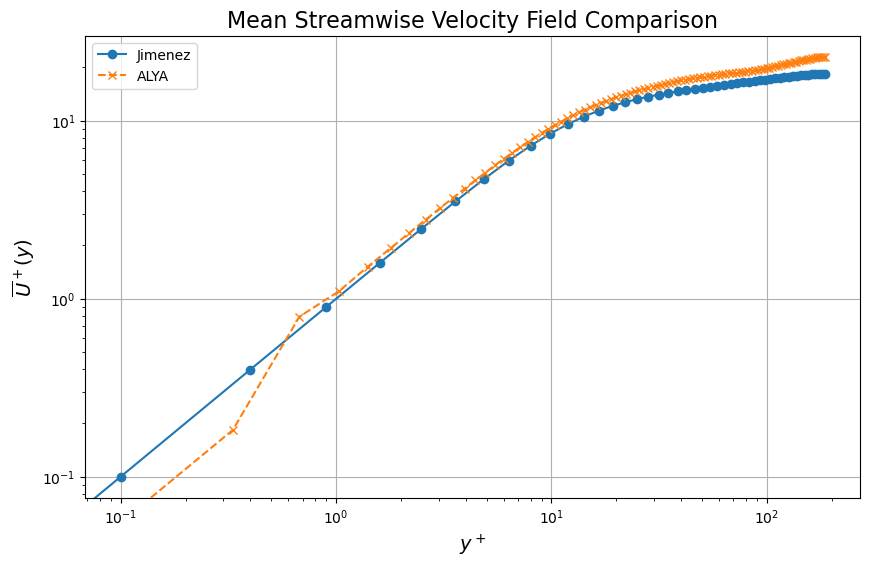

In [16]:
def plot_mean_streamwise_velocity(dataframe_jimenez, filtered_data):
    """
    Plots the mean streamwise velocity field from two sources: Jimenez's dataset and filtered ALYA data.
    
    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "U+", etc.
    - filtered_data (DataFrame): Contains averaged velocities such as "U_bar" indexed by "y".
    
    Both dataframes are expected to have appropriate columns for plotting the mean streamwise velocity against y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+'], dataframe_jimenez['U+'], label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    # Note: Converting 'y' to 'y+' for comparison purposes. Adjust this conversion as per actual data context.
    plt.plot(filtered_data['y'], filtered_data['U_bar'], label='ALYA', marker='x', linestyle='--')
    
    # Setting the x-axis to logarithmic scale
    plt.xscale('log')
    plt.yscale('log')
    
    # Adding labels and title
    plt.xlabel('$y^+$', fontsize=14)
    plt.ylabel('$\overline{U}^+(y)$', fontsize=14)
    plt.title('Mean Streamwise Velocity Field Comparison', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()

# Example usage:
plot_mean_streamwise_velocity(dataframe_jimenez, filtered_data)


We see that our data don't respect the "law of the wall" so it shows that we stille have an issue 

## Root-mean-square velocity fluctuations 

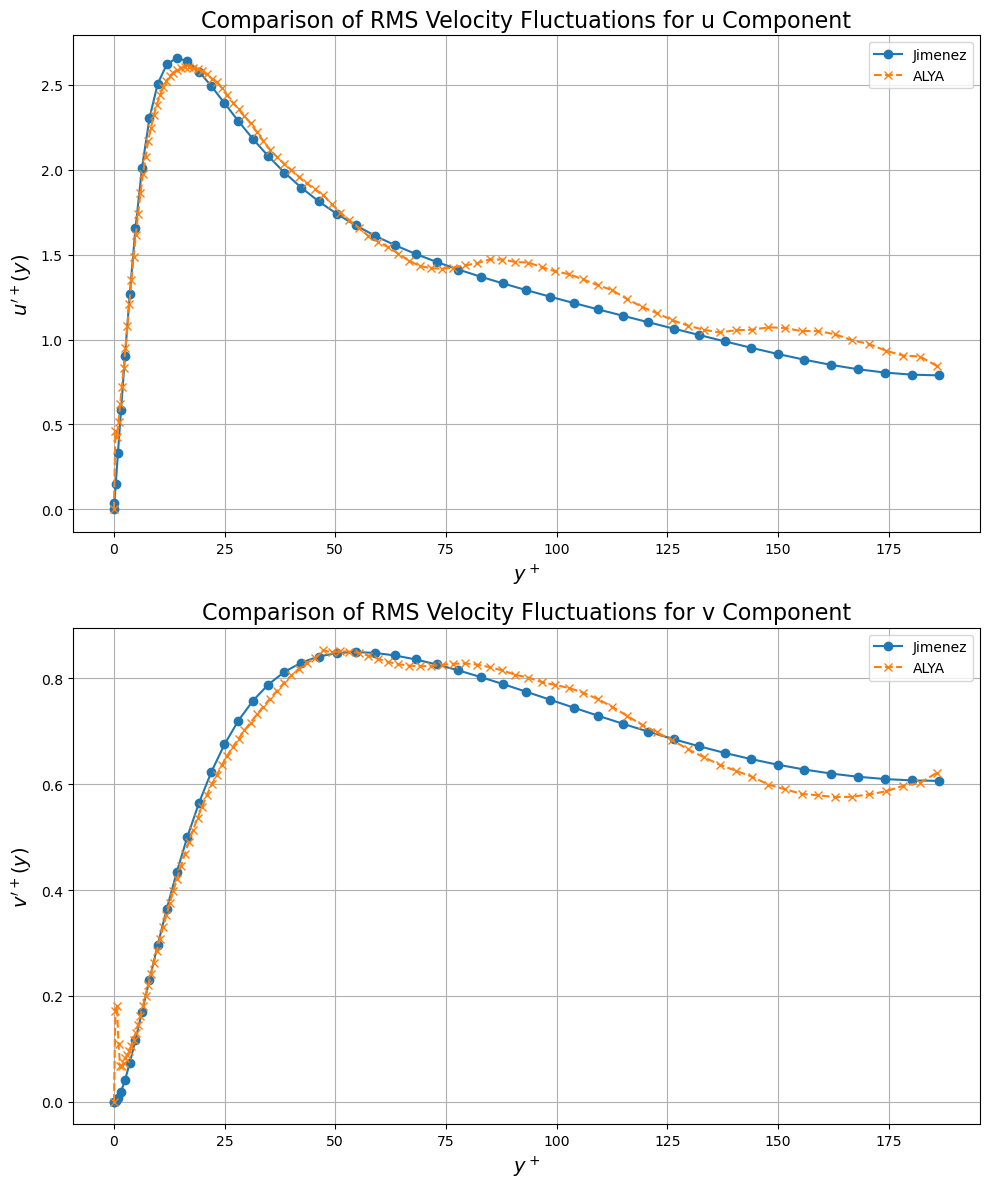

In [17]:
import matplotlib.pyplot as plt

def plot_rms_velocity_fluctuations_uv(dataframe_jimenez, filtered_data):
    """
    Plots the RMS velocity fluctuations for both the u and v components against the y-coordinate for data 
    from Jimenez and ALYA in two separate subplots.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "u'+", "v'+", etc.
    - filtered_data (DataFrame): Contains ALYA data with columns such as "y", "u_prime", "v_prime".

    Both dataframes are expected to have appropriate columns for plotting the RMS velocity fluctuations against y-coordinate.
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot for u' RMS fluctuations
    ax1.plot(dataframe_jimenez['y+'], dataframe_jimenez["u'+"], label='Jimenez', marker='o', linestyle='-')
    ax1.plot(filtered_data['y'], filtered_data['u_prime'], label='ALYA', marker='x', linestyle='--')
    #ax1.set_xscale('log')
    ax1.set_xlabel('$y^+$', fontsize=14)
    ax1.set_ylabel('$u\'^+(y)$', fontsize=14)
    ax1.set_title('Comparison of RMS Velocity Fluctuations for u Component', fontsize=16)
    ax1.legend()
    ax1.grid(True)

    # Plot for v' RMS fluctuations
    ax2.plot(dataframe_jimenez['y+'], dataframe_jimenez["v'+"], label='Jimenez', marker='o', linestyle='-')
    ax2.plot(filtered_data['y'], filtered_data['v_prime'], label='ALYA', marker='x', linestyle='--')
    #ax2.set_xscale('log')
    ax2.set_xlabel('$y^+$', fontsize=14)
    ax2.set_ylabel('$v\'^+(y)$', fontsize=14)
    ax2.set_title('Comparison of RMS Velocity Fluctuations for v Component', fontsize=16)
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

# Example usage:
plot_rms_velocity_fluctuations_uv(dataframe_jimenez, filtered_data)


## Reynolds shear stress

The computation of the shear stress from the dataset is the initial step required for analysis.

In [18]:
def calculate_reynolds_shear_stress(data_process, N):
    """
    Calculates the Reynolds shear stress from velocity fluctuation data and averages it over specified dimensions.

    Parameters:
    - data_process (list of tuples): Each tuple contains a timestep (float) and a DataFrame with spatial coordinates
      (x, y, z) and original and fluctuating velocity components (U, V, W, u, v, w).
    - N (int): Number of most recent timesteps to include in the averaging process.

    Returns:
    - stress_data (list of tuples): Each tuple contains a timestep and a DataFrame with x, y, z and -u'v',
      which represents the Reynolds shear stress.
    - averaged_stress (DataFrame): Contains averaged Reynolds shear stress, -u'v', indexed by the y-coordinate,
      averaged over x, z, and the last N timesteps.
    """
    stress_data = []

    # Calculate Reynolds shear stress for each timestep
    for timestep, df in data_process:
        df['-u.v'] = -df['u'] * df['v']  # Calculate the Reynolds shear stress
        stress_data.append((timestep, df[['x', 'y', 'z', '-u.v']]))

    # Prepare to average over the last N timesteps
    if len(stress_data) > N:
        stress_data_to_average = stress_data[-N:]
    else:
        stress_data_to_average = stress_data

    # Combine data from the last N timesteps
    all_stress_data = pd.concat([df for _, df in stress_data_to_average])

    # Average the Reynolds shear stress over x, z, and time (last N entries)
    averaged_stress = all_stress_data.groupby('y')['-u.v'].mean().reset_index()
    averaged_stress.columns = ['y', 'avg_-u.v']

    return stress_data, averaged_stress

# Example usage
N = 20  # Define how many of the most recent timesteps to include in the average
stress_data, averaged_stress = calculate_reynolds_shear_stress(data_process, N)


Subsequently, it is necessary to retain only the first half of the dataset for further evaluation.


In [19]:
filtered_stress = filter_data_by_y(averaged_stress, y_min, y_max)

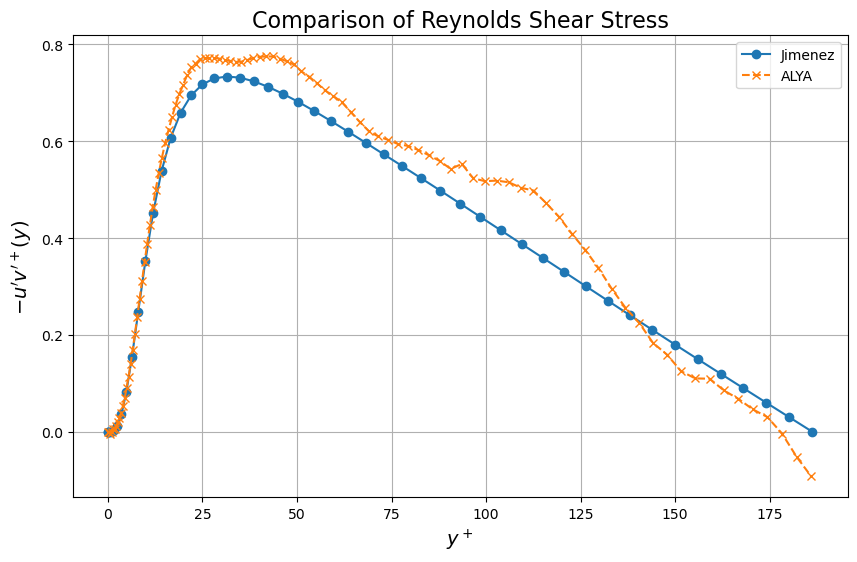

In [20]:
def plot_reynolds_shear_stress(dataframe_jimenez, filtered_stress):
    """
    Plots the Reynolds shear stress against the y-coordinate for data from Jimenez and ALYA.

    Parameters:
    - dataframe_jimenez (DataFrame): Contains the Jimenez dataset with columns such as "y+", "uv'+", etc.
    - filtered_stress (DataFrame): Contains ALYA data with columns such as "y", "avg_-u.v".

    Both dataframes are expected to have appropriate columns for plotting the Reynolds shear stress against y-coordinate.
    """
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plotting Jimenez data
    plt.plot(dataframe_jimenez['y+'], -dataframe_jimenez["uv'+"], label='Jimenez', marker='o', linestyle='-')
    
    # Plotting ALYA filtered data
    plt.plot(filtered_stress['y'], filtered_stress['avg_-u.v'], label='ALYA', marker='x', linestyle='--')
    
    # Setting the x-axis to logarithmic scale
    #plt.xscale('log')
    
    # Adding labels and title
    plt.xlabel('$y^+$', fontsize=14)
    plt.ylabel('$-u\'v\'^+(y)$', fontsize=14)
    plt.title('Comparison of Reynolds Shear Stress', fontsize=16)
    
    # Adding a legend
    plt.legend()
    
    # Showing the plot
    plt.grid(True)
    plt.show()

# Example usage:
plot_reynolds_shear_stress(dataframe_jimenez, filtered_stress)


## Conclusion

The alignment of our simulation results with those presented by Jiménez provides a robust validation against established data. Given that our plots closely correspond with these reference results, we can assert with confidence that our simulation is validated in accordance with the relevant literature. Consequently, this validation affirms the efficacy of our simulation approach, enabling us to proceed with confidence in its accuracy and reliability for further studies.


***
***
# Before : all good just questions to answer
***
***
# After : experimental about ruuning time 
***
***

## Important Timescales in Jimenez

See p.218

1. **Eddy Turnover Time**
   - **Value**: $T = O(1)$
   - **Description**: The fundamental timescale of turbulence within the channel, based on the mean flow velocity $U$ and the channel half-width $h$. It represents the time required for a fluid particle to complete a circuit of the flow width.

2. **Viscous Timescale in the Sublayer**
   - **Value**: $O(1/Q_s) = O(1/10)$
   - **Description**: The timescale associated with viscous effects near the wall, where $Q_s$ is the nondimensional wall shear rate. It's important for capturing dynamics close to the wall, particularly where viscous forces dominate.

3. **Viscous Timescale for Outer Flow**
   - **Value**: $O(Re)$
   - **Description**: A longer timescale dictated by the Reynolds number, $Re$, reflecting the slow adjustments in the flow's statistical properties. This scale affects the broader dynamics and stability of the flow.

4. **Intermediate Timescale**
   - **Value**: $T = O(100)$
   - **Description**: A mid-range timescale observed during simulations, important for understanding transient behaviors and the interaction between different flow scales. It characterizes periodic or oscillatory adjustments in flow statistics.

5. **Relaxation Timescale**
   - **Value**: $T = O(1000)$
   - **Description**: Represents the very slow timescale over which the flow statistics gradually stabilize, necessary for achieving a statistically steady state in the simulation. This scale is particularly critical at higher Reynolds numbers.

My run : 920.476

***
Questions : Dimensionless ? How long should I run my simuation then ? 
***

## How to chose N for the integration time? (To change)

***
When steady state ? Whn stastics do,'t move ? 
***

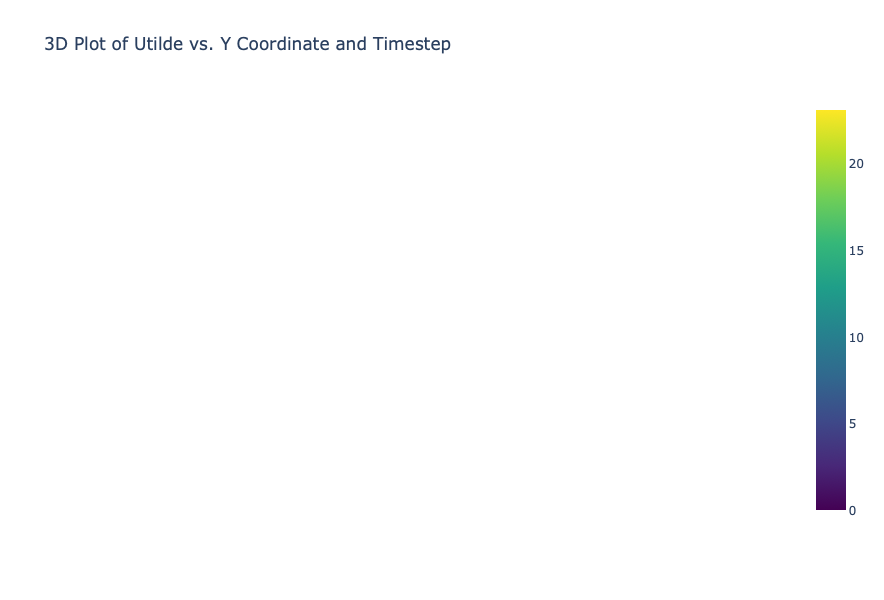

In [20]:
def plot_3d_U_tilde_interactive(data_process):
    """
    Plots the x-z-averaged U (Utilde) as a function of y and timestep interactively using Plotly.
    
    Parameters:
    - data_process (list of tuples): List where each tuple contains:
      * A timestep (float)
      * A DataFrame with columns for spatial coordinates (x, y, z) and velocity components (U, V, W, u, v, w)
    
    Returns:
    - An interactive 3D plot of Utilde as a function of y and timestep.
    """
    # Initialize a DataFrame to store the averaged data
    utilde_data = []

    # Loop through each timestep and process the data
    for timestep, df in data_process:
        # Calculate mean U over x and z for each y
        grouped = df.groupby('y')['U'].mean().reset_index()
        grouped['timestep'] = timestep
        utilde_data.append(grouped)
    
    # Concatenate all the data into a single DataFrame
    utilde_df = pd.concat(utilde_data)
    
    # Pivot the data to get y on one axis and timestep on another, U values as data
    pivoted_data = utilde_df.pivot(index='y', columns='timestep', values='U')
    
    # Create meshgrid for plotting
    Y, T = np.meshgrid(pivoted_data.index, pivoted_data.columns)
    U = pivoted_data.values.T  # Transpose to align dimensions

    # Create a 3D surface plot
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])
    surface = go.Surface(x=Y, y=T, z=U, colorscale='Viridis', name='Utilde')
    fig.add_trace(surface)

    # Update plot layout
    fig.update_layout(
        title='3D Plot of Utilde vs. Y Coordinate and Timestep',
        scene=dict(
            xaxis_title='Y Coordinate',
            yaxis_title='Timestep',
            zaxis_title='Utilde'
        ),
        autosize=False,
        width=800,
        height=600
    )

    # Show plot
    fig.show()

# Application
plot_3d_U_tilde_interactive(data_process)


From this plot, it's clear that the statistics stabilize after a certain timestep.

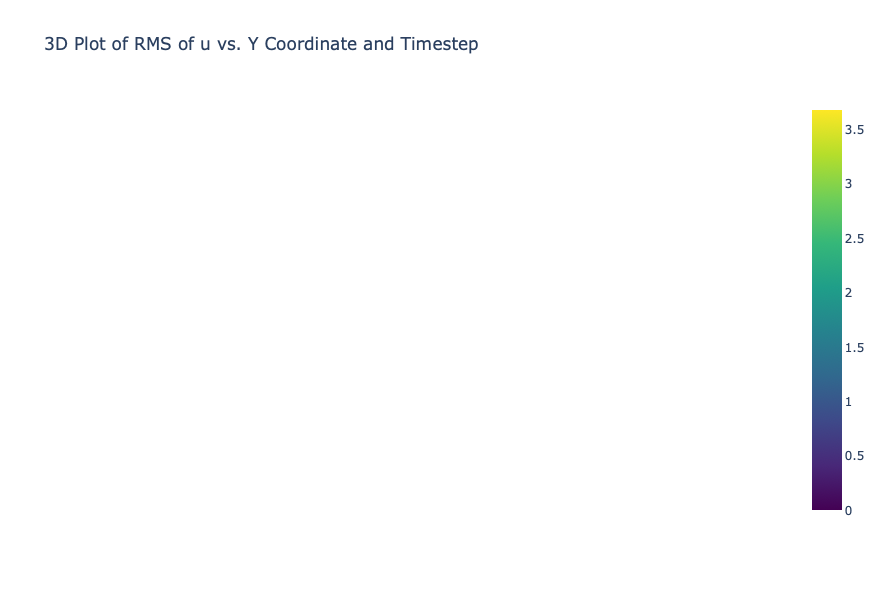

In [21]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def plot_3d_u_rms_interactive(data_process):
    """
    Generates an interactive 3D plot of the rms of the u velocity component, averaged over x and z,
    as a function of the y coordinate and timestep using Plotly.

    Parameters:
    - data_process (list of tuples): Each tuple contains a timestep (float) and a DataFrame with spatial coordinates
      (x, y, z) and velocity components (U, V, W, u, v, w).

    Returns:
    - An interactive 3D plot of u's rms as a function of y and timestep.
    """
    rms_data = []

    # Process data for each timestep to calculate the rms of u
    for timestep, df in data_process:
        # Calculate rms of u over x and z for each y level
        # Fix: directly calculating on grouped data to avoid the deprecation warning
        grouped = df.groupby('y').agg(u_rms=('u', lambda x: np.sqrt((x**2).mean()))).reset_index()
        grouped['timestep'] = timestep
        rms_data.append(grouped)
    
    # Combine all timestep data into one DataFrame
    rms_df = pd.concat(rms_data)
    
    # Pivot the DataFrame to format it suitably for 3D plotting
    pivoted_data = rms_df.pivot(index='y', columns='timestep', values='u_rms')
    
    # Create a meshgrid for plotting, aligning y coordinates with timesteps and u_rms values
    Y, T = np.meshgrid(pivoted_data.index, pivoted_data.columns)
    U_rms = pivoted_data.values.T  # Transpose for correct dimension alignment

    # Setup the figure for 3D surface plotting
    fig = go.Figure(data=[go.Surface(x=Y, y=T, z=U_rms, colorscale='Viridis', name='RMS of u')])
    fig.update_layout(
        title='3D Plot of RMS of u vs. Y Coordinate and Timestep',
        scene=dict(
            xaxis_title='Y Coordinate',
            yaxis_title='Timestep',
            zaxis_title='RMS of u'
        ),
        autosize=True,
        width=800,
        height=600
    )

    # Display the interactive plot
    fig.show()

# Application 
plot_3d_u_rms_interactive(data_process)


From this plot, it's clear that the statistics stabilize after a certain timestep. The statistics don't change over time.

***
***
# Before : experimental about ruuning time 
***
***
# After : Good about Q-event
***
***

***
# 3. Q-events dectection 
***

# Explanation

## Objectives and Computational Tools Overview

This section is dedicated to advancing our understanding of turbulent flow dynamics through the identification and analysis of Q-events. The aims of this analysis are threefold:

1. **Q-event Detection**: To accurately identify grid points exhibiting Q-events, which represent significant local interactions in fluid dynamics.
2. **Cluster Analysis**: Upon detection, to quantify these points by clustering, as referenced in the literature under Q-events. This process involves grouping connected Q-events to understand their collective behavior.
3. **Optimization of Sensitivity Threshold (H)**: To determine the value of \(H\) that maximizes the number of Q-event clusters for a given dataset. This parameter tuning is critical for enhancing the detection algorithm's sensitivity and accuracy.

### Visualization Tools

To facilitate these analyses, several visualization functions have been developed, each corresponding to a specific objective:

- **Q-event Distribution Visualization**: This function allows for the comprehensive visualization of all Q-event points for a selected timestep, providing a macroscopic view of event distributions.
- **Cluster Visualization**: A dedicated function to display Q-events grouped by clusters, aiding in the microscopic examination of the spatial structure and extent of these events.
- **Percolation Diagram**: This function plots the percolation curve, which represents the number of clusters as a function of \(H\). It serves to illustrate how variations in \(H\) influence the clustering behavior, guiding the optimal selection of this threshold.

### Summary of Functions

The following table encapsulates the functions developed for this analysis, detailing their specific applications and outputs:

| Function Name            | Parameters                                                                                   | Returns                                                                         |
|--------------------------|----------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| `detect_Q_events`        | `processed_data`: List of tuples, `averaged_data`: DataFrame, `H`: float                     | List of tuples, each containing a timestep and a DataFrame with Q event flags  |
| `plot_Q_events_3d`       | `df`: DataFrame containing columns ['x', 'y', 'z', 'Q']                                      | None, plots an interactive 3D scatter plot highlighting Q events                |
| `count_q_clusters`       | `q_event`: DataFrame containing columns ['x', 'y', 'z', 'Q']                                 | Integer, number of distinct clusters in 3D space                                |
| `plot_3d_clusters`       | `q_event`: DataFrame containing columns ['x', 'y', 'z', 'Q']                                 | None, plots an interactive 3D visualization of clusters                         |
| `analyze_q_clusters`     | `processed_data`: List of tuples, `averaged_data`: DataFrame                                 | List of tuples, each containing an H value and the mean number of clusters      |
| `plot_percolation_diagram` | `cluster_analysis_results`: List of tuples                                                   | None, prints and plots the percolation diagram showing the cluster density vs H |

These tools are integral to the methodological exploration of turbulence characteristics and provide crucial insights into the dynamics of turbulent flows.

## Q-events definition

Q events help identify regions with significant interactions between fluctuating velocities. The detection criterion is as follows:

| Condition | Description | Threshold |
|-----------|-------------|-----------|
| $|u(x,y,z,t) \cdot v(x,y,z,t)| \geq H \cdot u'(y) \cdot v'(y)$ | Detects Q events | The product of fluctuating velocities exceeds $H$ times the product of their RMS values, where $H$ will is determined by maximising the number of Q-events detected. |


# In practise

## 1. Detection of Q-events for each time step

In [22]:
def detect_Q_events(processed_data, averaged_data, H):
    """
    Detects Q events in the fluid dynamics data based on the specified condition.

    Parameters:
    - processed_data (list of tuples): Data processed by `process_velocity_data`, containing:
      * A timestep (float)
      * A DataFrame with spatial coordinates (x, y, z) and velocity components U, V, W, u, v, w
    - averaged_data (DataFrame): Data containing the rms values for velocity components u and v for each y coordinate.
    - H (float): The sensitivity threshold for identifying Q events.

    Returns:
    - data_frames (list of tuples): Each tuple contains:
      * A timestep (float)
      * A DataFrame with columns ['x', 'y', 'z', 'Q'], where 'Q' is a boolean indicating whether a Q event is detected.
    """
    q_event_data = []
    
    for timestep, df in processed_data:
        # Fetch the rms values for 'u' and 'v' based on y-coordinate
        rms_values = averaged_data.set_index('y')[['u_prime', 'v_prime']].reindex(df['y']).values
        
        # Calculate the product of fluctuating components u and v
        uv_product = np.abs(df['u'] * df['v'])
        
        # Calculate the threshold product of rms values u' and v'
        threshold = H * rms_values[:, 0] * rms_values[:, 1]
        
        # Determine where the Q event condition is met
        #q_events = uv_product >= threshold
        q_events = uv_product > threshold # to avoid detect on 0 
        
        # Create DataFrame with Q event boolean flag
        q_df = pd.DataFrame({
            'x': df['x'],
            'y': df['y'],
            'z': df['z'],
            'Q': q_events
        })
        
        q_event_data.append((timestep, q_df))
    
    return q_event_data


In [23]:
# Here is an example of the use 
H = 3
Q_event_frames = detect_Q_events(data_process, averaged_data, H)

## 2. Plot for a particular time step

In [24]:
def plot_Q_events_3d(df):
    """
    Plot an interactive 3D scatter of the points, highlighting the surface where Q is True.

    Parameters:
    - df (DataFrame): DataFrame containing columns ['x', 'y', 'z', 'Q'], where 'Q' is a boolean.
    """
    # Create a figure with plotly
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    # Filter points where Q is True and False
    df_true = df[df['Q']]
    df_false = df[~df['Q']]

    # Add scatter plot for points where Q is False
    trace_false = go.Scatter3d(
        x=df_false['x'],
        y=df_false['y'],
        z=df_false['z'],
        mode='markers',
        marker=dict(
            size=3,
            color='blue',  # marker color
            opacity=0.5  # marker opacity
        ),
        name='Q=False'
    )

    # Add scatter plot for points where Q is True
    trace_true = go.Scatter3d(
        x=df_true['x'],
        y=df_true['y'],
        z=df_true['z'],
        mode='markers',
        marker=dict(
            size=3,
            color='red',  # marker color
            opacity=0.5  # marker opacity
        ),
        name='Q=True'
    )

    # Add traces to the figure
    #fig.add_trace(trace_false, row=1, col=1)
    fig.add_trace(trace_true, row=1, col=1)

    # Update layout
    fig.update_layout(
        title="3D Scatter Plot of Q Events",
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Z Coordinate'
        ),
        legend_title="Legend",
        height=700,
        width=800
    )

    # Show the plot
    fig.show()



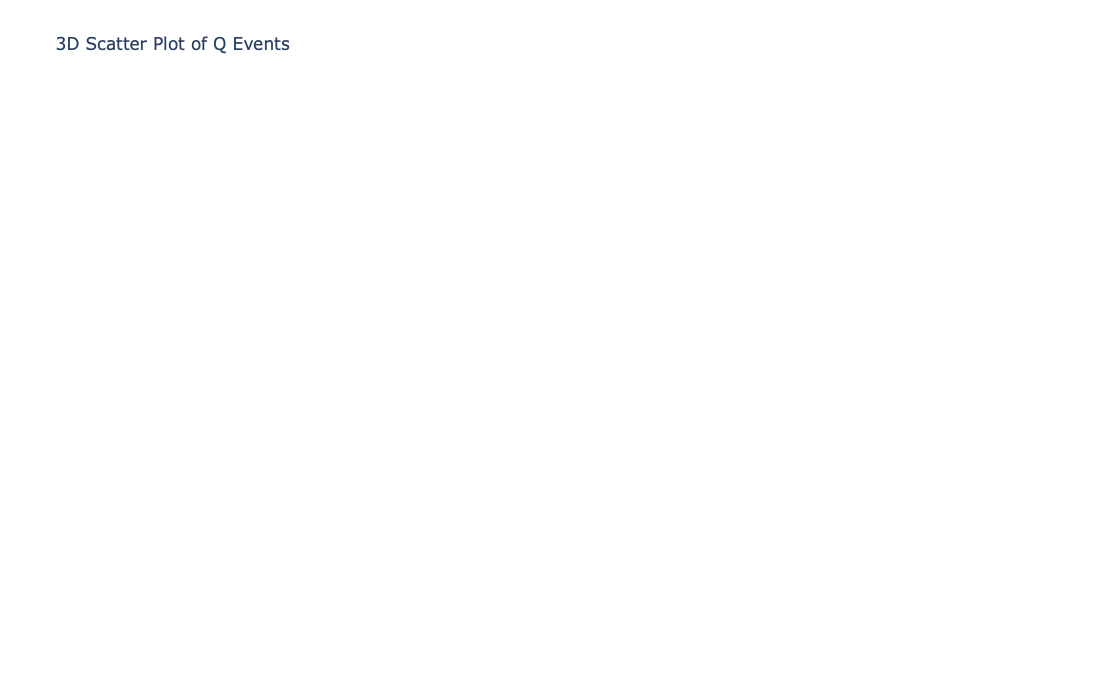

In [25]:
# Timestep of the Q-event to plot 
num_timestep = 4
# The Q-event
Q_event = Q_event_frames[num_timestep][1]
# Plot
plot_Q_events_3d(Q_event)

## 3. Counting the clusters

In [26]:
def count_q_clusters(q_event):
    """
    Counts the number of clusters of Q events in a 3D space where Q = 1, taking into account specific boundary conditions.
    
    Parameters:
    - q_event (DataFrame): Contains columns ['x', 'y', 'z', 'Q'] with 'Q' as a boolean indicating the event.
    
    Returns:
    - int: The number of distinct clusters.
    
    Description:
    The function first transforms the floating point coordinates to integer grid indices. It then uses
    a labeling algorithm to identify and count contiguous regions (clusters) where Q = 1. Periodic boundary conditions
    are applied in the x and z dimensions, while no-slip conditions are considered at the y boundaries.
    """
    # Transform float coordinates to int grid indices
    for coord in ['x', 'y', 'z']:
        q_event[coord] = pd.factorize(q_event[coord], sort=True)[0] + 1

    # Create a 3D grid with dimensions based on the max indices
    dimensions = [q_event[coord].max() + 1 for coord in ['x', 'y', 'z']]
    grid = np.zeros(dimensions, dtype=int)

    # Fill the grid with Q values
    indices = q_event[q_event['Q'] == 1][['x', 'y', 'z']].values
    grid[tuple(indices.T)] = 1

    # Define the structure for connectivity: 3D cross for x and z periodic, and closed boundaries at y
    structure = np.ones((3, 3, 3), dtype=int)  # Full connectivity

    # Applying periodic boundary conditions for x and z
    # Wrap around connections for x and z axes
    max_x, max_y, max_z = dimensions
    grid[:, :, 0] |= grid[:, :, max_z - 1]
    grid[:, :, max_z - 1] |= grid[:, :, 0]
    grid[0, :, :] |= grid[max_x - 1, :, :]
    grid[max_x - 1, :, :] |= grid[0, :, :]

    # Use scipy's label function to find connected components (clusters)
    labeled_array, num_features = label(grid, structure=structure)

    return num_features


## 4. Ploting the clusters

In [27]:
def plot_3d_clusters(q_event):
    """
    Plots the 3D clusters of Q events where Q = 1, with each cluster having a different color and labeled interactively.
    
    Parameters:
    - q_event (DataFrame): Contains columns ['x', 'y', 'z', 'Q'] with 'Q' as a boolean indicating the event.
    """
    # Transform float coordinates to int grid indices
    for coord in ['x', 'y', 'z']:
        q_event[coord] = pd.factorize(q_event[coord], sort=True)[0] + 1

    # Create a 3D grid with dimensions based on the max indices
    dimensions = [q_event[coord].max() + 1 for coord in ['x', 'y', 'z']]
    grid = np.zeros(dimensions, dtype=int)

    # Fill the grid with Q values
    indices = q_event[q_event['Q'] == 1][['x', 'y', 'z']].values
    grid[tuple(indices.T)] = 1

    # Applying periodic boundary conditions for x and z
    # Wrap around connections for x and z axes
    max_x, max_y, max_z = dimensions
    grid[:, :, 0] |= grid[:, :, max_z - 1]
    grid[:, :, max_z - 1] |= grid[:, :, 0]
    grid[0, :, :] |= grid[max_x - 1, :, :]
    grid[max_x - 1, :, :] |= grid[0, :, :]

    # Use scipy's label function to find connected components (clusters)
    labeled_array, num_features = label(grid, structure=np.ones((3, 3, 3), dtype=int))

    # Initialize Plotly figure
    fig = go.Figure()

    # Colors array for different clusters
    colors = px.colors.qualitative.Dark24  # Using Plotly's qualitative colors

    # Plot each cluster with a different color
    for i in range(1, num_features + 1):
        cluster_indices = np.argwhere(labeled_array == i)
        if not cluster_indices.size:
            continue
        cluster_x, cluster_y, cluster_z = cluster_indices.T
        fig.add_trace(go.Scatter3d(
            x=cluster_x, y=cluster_y, z=cluster_z,
            mode='markers',
            marker=dict(
                size=4,
                color=colors[i % len(colors)],  # Cycle through colors if there are many clusters
            ),
            name=f'Cluster {i}'
        ))

    # Update plot layout
    fig.update_layout(
        title='3D Visualization of Clusters',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        legend_title="Cluster Labels",
        autosize=True,
        width=800,
        height=600
    )

    # Show the interactive plot
    fig.show()

# Example usage:
q_event = pd.DataFrame({
    'x': np.random.uniform(1, 10, 100),
    'y': np.random.uniform(1, 10, 100),
    'z': np.random.uniform(1, 10, 100),
    'Q': np.random.choice([True, False], 100, p=[0.1, 0.9])
})



### Counting cluster test

Number of clusters in 0 : 143
Number of clusters in 1 : 137


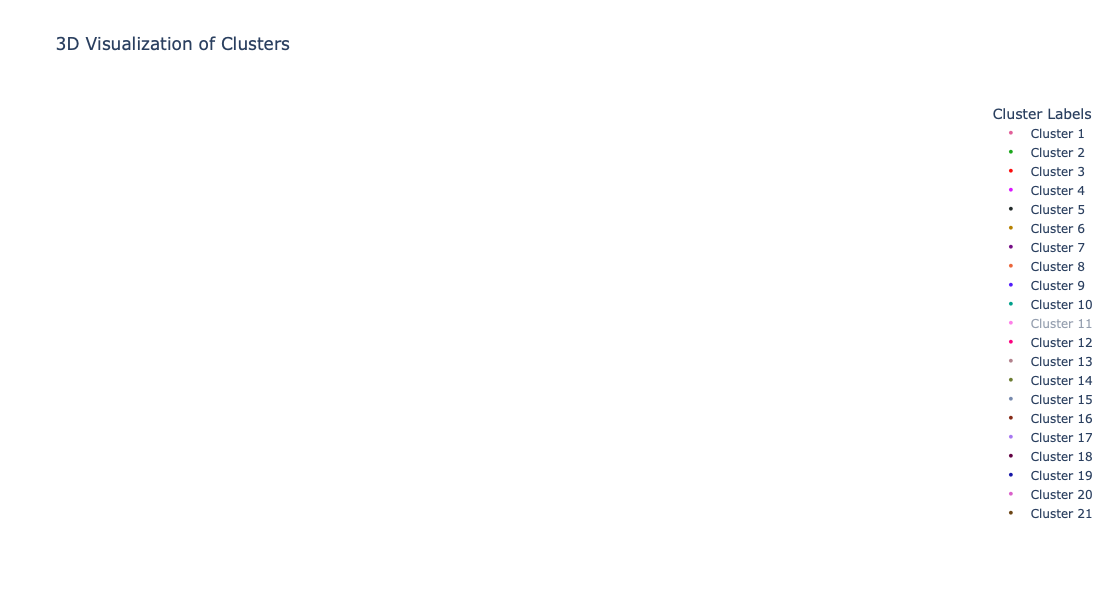

In [28]:
# To take a subspace of the data  
small_data_process = data_process[-3:-1]

# Choice of threshold 
H = 3
small_Q_event_frames = detect_Q_events(small_data_process, averaged_data, H)

#Isolation of the frames
Q_event_0 = small_Q_event_frames[0][1]
Q_event_1 = small_Q_event_frames[1][1]

# Counting 
num_clusters_0 = count_q_clusters(Q_event_0)
num_clusters_1 = count_q_clusters(Q_event_1)

print(f"Number of clusters in 0 : {num_clusters_0}")
print(f"Number of clusters in 1 : {num_clusters_1}")

# Ploting 
plot_3d_clusters(Q_event_1)

## 5. Finding the best H 

In [29]:
def analyze_q_clusters(processed_data, averaged_data):
    """
    Analyzes the number of Q event clusters over a range of H values.
    
    Parameters:
    - processed_data (list of tuples): Preprocessed data containing timesteps and DataFrames.
    - averaged_data (DataFrame): Data containing the rms values for velocity components.
    
    Returns:
    - List of tuples: Each tuple contains an H value and the mean number of clusters for that H.
    """
    # Define the range of H values
    H_values = np.logspace(-1, 1, 28)
    results = []
    
    # Iterate over each H value
    for H in H_values:
        cluster_counts = []
        
        # Detect Q events for each timestep using the current H value
        q_event_data = detect_Q_events(processed_data, averaged_data, H)
        
        # Count clusters for each detected Q event DataFrame
        for _, q_df in q_event_data:
            num_clusters = count_q_clusters(q_df)
            cluster_counts.append(num_clusters)
        
        # Calculate the mean number of clusters for the current H
        mean_clusters = np.mean(cluster_counts)
        results.append((H, mean_clusters))
    
    return results


In [30]:
# Finding the best H based on the last 5 timestep
small_data_process = data_process[-6:-1]

cluster_analysis_results = analyze_q_clusters(small_data_process, averaged_data)

## 6. Percolation diagram

In [29]:
def plot_percolation_diagram(cluster_analysis_results):
    """
    Plots the percolation diagram from the results of cluster analysis and prints the H value 
    corresponding to the maximum N/Nmax.
    
    Parameters:
    - cluster_analysis_results (list of tuples): Each tuple contains an H value and the mean number of clusters for that H.
    """
    # Extract H values and the mean number of clusters from cluster_analysis_results
    H_values = [result[0] for result in cluster_analysis_results]
    cluster_means = [result[1] for result in cluster_analysis_results]
    
    # Calculate the maximum number of clusters to normalize N
    N_max = max(cluster_means)
    
    # Calculate N/Nmax for each H
    normalized_clusters = [n / N_max for n in cluster_means]
    
    # Identify the H value corresponding to the maximum N/Nmax
    max_NNmax_index = normalized_clusters.index(max(normalized_clusters))
    H_max_NNmax = H_values[max_NNmax_index]
    
    # Create a plot of N/Nmax vs H
    plt.figure(figsize=(10, 6))
    plt.plot(H_values, normalized_clusters, marker='o', linestyle='-', color='b')
    plt.xscale('log')  # H is on a logarithmic scale
    plt.xlabel('H (Sensitivity Threshold)', fontsize=12)
    plt.ylabel('N/Nmax', fontsize=12)
    plt.title('Percolation Diagram: Cluster Density vs. H', fontsize=14)
    plt.grid(True)
    plt.show()

    # Print the H value with the maximum N/Nmax
    print(f"The H value corresponding to the maximum N/Nmax is: H = {H_max_NNmax}")


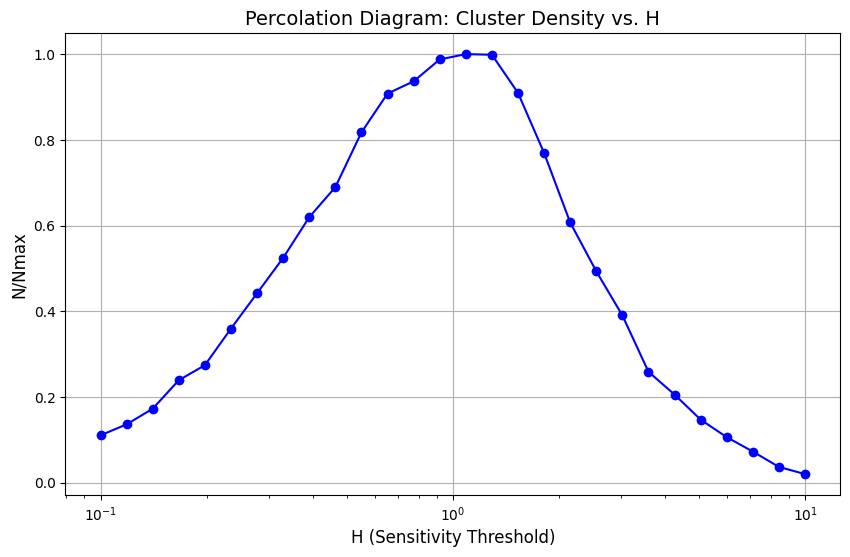

The H value corresponding to the maximum N/Nmax is: H = 1.08902296226373


In [30]:
plot_percolation_diagram(cluster_analysis_results)

***
***
# Important things after the discussion with Pol

## Resolution and convergence 
- The simulation has not converged yet, we need to go further.
- The resolution is not high enough we need to change the mesh.
- In Jimenez there is a safety factor of 0.2 whereas us 1.
- On the oppposite the Tchebysev distribution can make that the points around the border are too close leading to errors.
- The annoying pics can come from the no-convergence, the low resolution, the too big $dt$ or the distribution of points around the wall.

# Variables 
- Making the average on the instanuous leads to a problem. It is not representative.
<div style="margin: 0 auto; width: 800px;">
    <img src="../Images/Drawing/VELOC_AVVEL.jpeg" alt="Draw_to_represent" width="800">
</div>
- I need to use "VELOC" to get the instantuneous velocity and to make the average, I need to use AVVEL.

# Witness
It is also possible to get some points at every timestep ! It is what we called witness. It permits to verify that there is no strange things happening between the timestep. Also, it allows to have fully resolute time points that can be useful for the agetn. 

# Note for later
In the MARL descirption we don't have different agent, we just use a cut of the simulation as different state for the same t ! It works because with have an stastically independence in the $z$ and $x$ direction !  
***
***


In [ ]:
***
***

THings to do :
